In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
from variational_auto_encoder import VariationalAutoEncoder
from stacked_mnist import StackedMNISTData, DataMode
import numpy as np
import matplotlib.pyplot as plt
from verification_net import VerificationNet
from utils import display_images

In [174]:
variational_auto_encoder = VariationalAutoEncoder(latent_dim=8)
variational_auto_encoder.model.summary()

Model: "model_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_184 (Conv2D)         (None, 13, 13, 32)        320       
                                                                 
 conv2d_185 (Conv2D)         (None, 6, 6, 64)          18496     
                                                                 
 flatten_80 (Flatten)        (None, 2304)              0         
                                                                 
 dense_134 (Dense)           (None, 256)               590080    
                                                                 
 dense_135 (Dense)           (None, 16)                4112      
                                                                 
 independent_normal_25 (Inde  ((None, 8),              0  

In [175]:
variational_auto_encoder.train(epochs=20, force_relearn=False)

./models/vae
Epoch 1/20
Cause: could not parse the source code of <function VariationalAutoEncoder.__init__.<locals>.<lambda> at 0x7f85df61ad30>: no matching AST found among candidates:
# coding=utf-8
(lambda input, output: (- output.log_prob(input)))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function VariationalAutoEncoder.__init__.<locals>.<lambda> at 0x7f85df61ad30>: no matching AST found among candidates:
# coding=utf-8
(lambda input, output: (- output.log_prob(input)))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
469/469 [==============================] - 34s 70ms/step - loss: 179.3399 - val_loss: 118.6769
Epoch 2/20
469/469 [==============================] - 32s 69ms/step - loss: 110.5715 - val_loss: 104.6638
Epoch 3/20
469/469 [==============================] - 33s 70ms/step - loss: 103.4290 - val_loss: 100.8960
Epoch 4/20
469/469 [=====

# Mono Images

In [176]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

### Reconstruction results

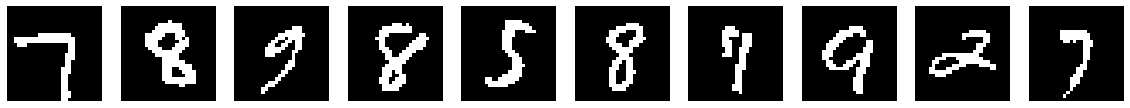

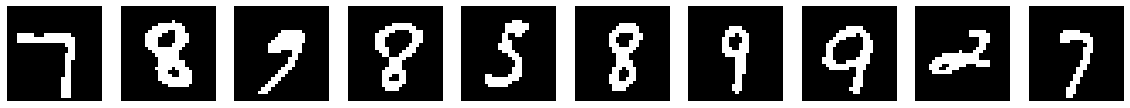

In [177]:
reconstructed = variational_auto_encoder.reconstruct(x_test)

display_images(x_test, 10)
display_images(reconstructed, 10)

In [178]:
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
_, acc_ae = net.check_predictability(data=reconstructed, correct_labels=y_test)
print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")


Accuracy of Reconstruction: 91.70%


### Autoencoder as a generator

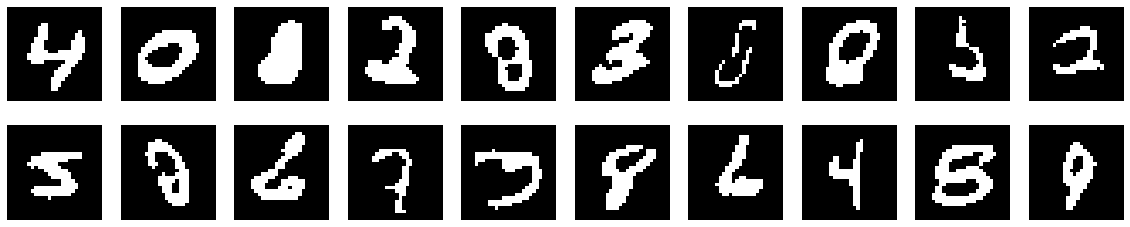

In [179]:
generated = variational_auto_encoder.generate_new_samples()
display_images(generated, 20)

In [180]:
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 74.50%


# Color Images

In [181]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=10000)
x_test = x_test.astype(np.float64)

### Reconstruction results

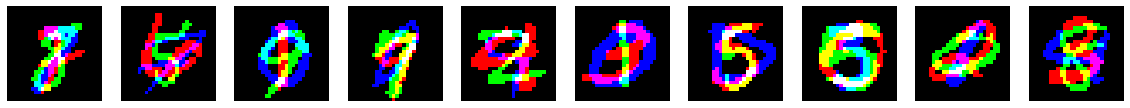

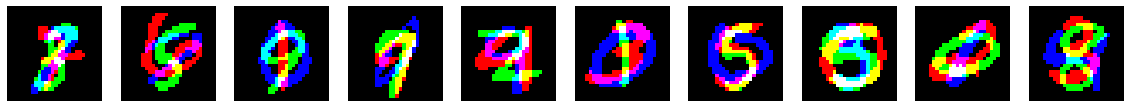

In [182]:
reconstructed = variational_auto_encoder.reconstruct(x_test)

display_images(x_test, 10, color=True)
display_images(reconstructed, 10, color=True)

In [183]:
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
_, acc_ae = net.check_predictability(data=reconstructed, correct_labels=y_test, tolerance=0.5)
print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")

Accuracy of Reconstruction: 80.46%


### Variational-Auto-Encoder as a generator

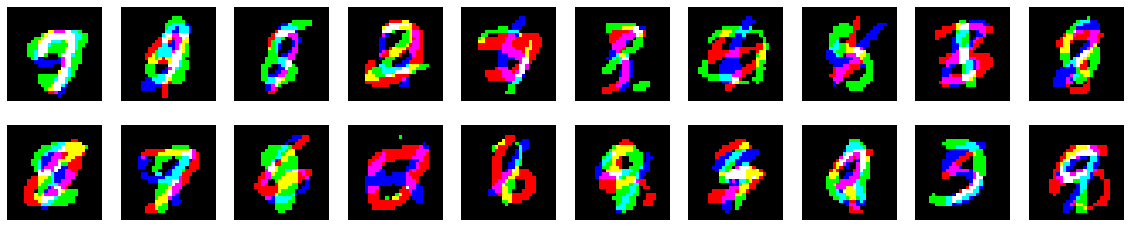

In [184]:
generated = variational_auto_encoder.generate_new_samples(no_channels=3)
display_images(generated, 20, color=True)

In [185]:
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 15.00%
Predictability: 41.80%


# Variational-Auto-Encoder as anomaly detector

In [194]:
vae_anomaly = VariationalAutoEncoder(latent_dim=8, missing=True)
vae_anomaly.train(epochs=20, force_relearn=False)

./models/vae_missing
True
Read model from file, so I do not retrain


### Mono images

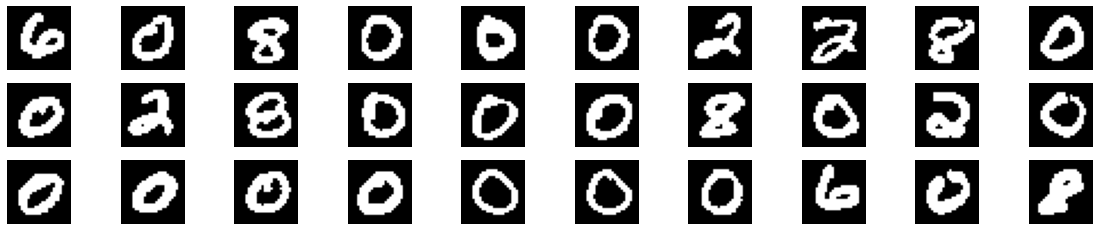

In [198]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

anomalies = vae_anomaly.get_anomalies(x_test, k=30, N=2000)
display_images(x_test[anomalies], 30)

### Color images

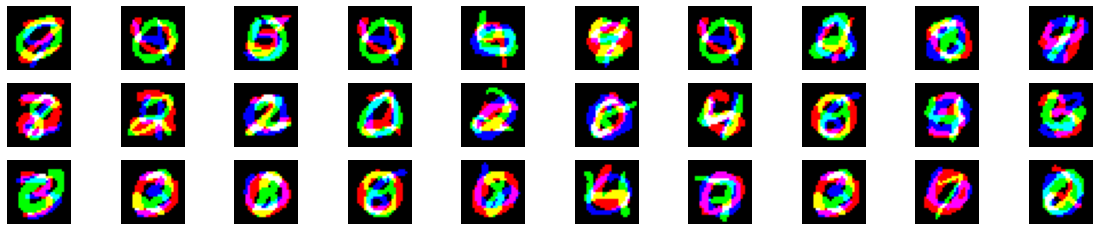

In [199]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)
x_test = x_test.astype(np.float64)

anomalies = vae_anomaly.get_anomalies(x_test, k=30, N=2000)
display_images(x_test[anomalies], 30, color=True)